## 한글 깨짐 방지용 코드

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rc
import platform

# 시스템별 폰트 지정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')  # 윈도우일 경우
elif platform.system() == 'Darwin':  # MacOS
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='NanumGothic')  # 리눅스일 경우 추천

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

## 라이브러리 불러오기

In [2]:
!pip install geopandas

import geopandas as gpd
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## 데이터셋 불러오기

In [3]:
seoul_gdf = gpd.read_file('./data/서울_자치구_경계_2017.geojson')
final_df = pd.read_csv('./data/최종 데이터셋.csv', encoding='utf-8')

# 일반 가구 대비 중증 정신 질환자 비율
final_df['중증정신질환자 비율'] = final_df['중증정신질환 등록회원 수'] / final_df['일반가구']
final_df.rename(columns={'ㄱ': 'SIG_KOR_NM'}, inplace=True)

# 지도 데이터와 통계 데이터를 자치구 이름 기준으로 병합
# 공간 정보 + 사회 지표가 결합된 GeoDataFrame 생성
merged_gdf = seoul_gdf.merge(final_df, on='SIG_KOR_NM')

## 엘보우 기법 + 실루엣 스코어 계산

In [5]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

cluster_vars = ['1인가구 비율', '중증정신질환자 비율', '복지 인프라 밀도', '고독사 위험지수']
X = merged_gdf[cluster_vars]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
# 엘보우 메소드
inertias = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# 실루엣 점수 계산
sil_scores = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

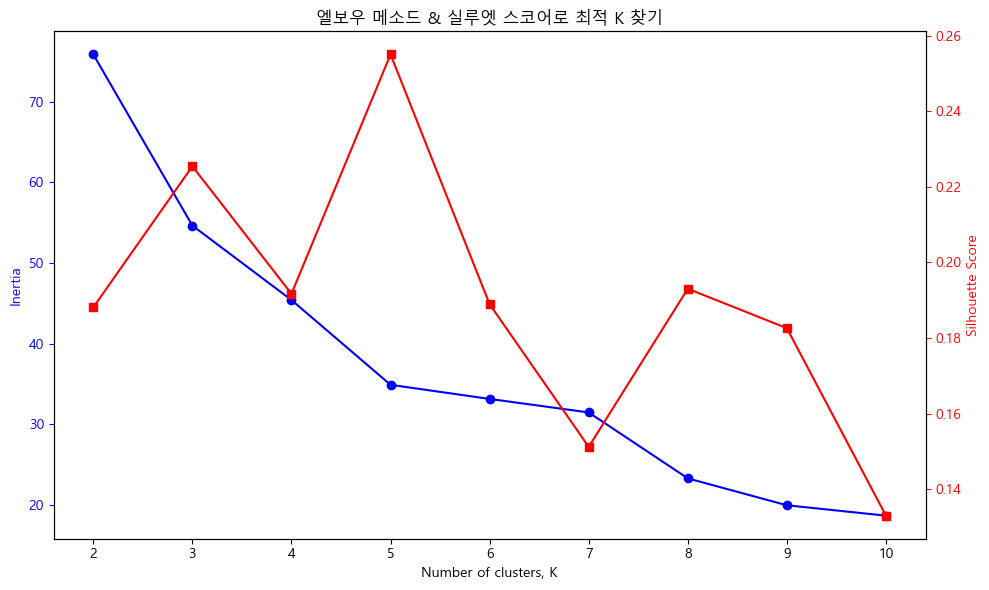

In [7]:
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.plot(K_range, inertias, 'b-o', label='Elbow (Inertia)')
ax1.set_xlabel('Number of clusters, K')
ax1.set_ylabel('Inertia', color='b')
ax1.tick_params(axis='y', colors='b')

ax2 = ax1.twinx()
ax2.plot(K_range, sil_scores, 'r-s', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color='r')
ax2.tick_params(axis='y', colors='r')

plt.title('엘보우 메소드 & 실루엣 스코어로 최적 K 찾기')
fig.tight_layout()
plt.show()

In [8]:
# 최적 K값 찾기
optimal_k_elbow = K_range[np.argmin(np.diff(inertias)) + 1]
optimal_k_sil = K_range[np.argmax(sil_scores)]

print(f'엘보우 메소드 최적 K: {optimal_k_elbow}')
print(f'실루엣 점수 최적 K: {optimal_k_sil}')

kmeans_elbow = KMeans(n_clusters=optimal_k_elbow, random_state=42)
merged_gdf['cluster_elbow'] = kmeans_elbow.fit_predict(X_scaled)

kmeans_sil = KMeans(n_clusters=optimal_k_sil, random_state=42)
merged_gdf['cluster_silhouette'] = kmeans_sil.fit_predict(X_scaled)

엘보우 메소드 최적 K: 3
실루엣 점수 최적 K: 5


**파란 선(Inertia, 왼쪽 Y축):군집 수(K)를 늘릴수록 점점 감소하는 값**
- Inertia는 각 군집 내 데이터 점들이 군집 중심(centroid)에서 얼마나 떨어져 있는지, 전체 거리의 제곱합
- 값이 작아질수록 군집화가 잘 되어 있다는 의미이지만, K값을 계속 증가시켜도 감소폭이 점점 작아지다가 완만해짐
- 이 곡선이 꺾이는 지점이 바로 엘보우(Elbow) 지점으로, 여기서 K값(그래프에서는 3)이 최적 군집 개수 추천 값
- K=3 이후에는 inertia 감소폭이 작아지므로 더 분할할 필요성이 적다는 뜻

**빨간선(Silhouette Score, 오른쪽 Y축):Silhouette Score는 군집 내 데이터의 응집도와 군집 간 분리도를 함께 고려한 지표**
- 값이 클수록(최대 1) 군집화 결과가 더 좋다는 의미
- 파란선과 달리 실루엣 점수는 K에 따라 증감이 반복되거나 급격하게 변할 수 있음
- K값을 달리할 때 각 K에서의 실루엣 점수(빨간선)를 비교하여 가장 큰 값(그래프에서 K=5)이 실루엣 기준 최적 군집 수


## 클러스터링 적용 (K-Means, K-Medoid, Hierarchical, DBSCAN)

In [9]:
# ==============================
# K=5 통일: KMeans / K-Medoids / Hierarchical / DBSCAN
# ==============================

import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import pairwise_distances
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

plt.rcParams['axes.unicode_minus'] = False

In [10]:
# ------------------------------
# 1) 데이터 로드 & 전처리
# ------------------------------
seoul_gdf = gpd.read_file('./data/서울_자치구_경계_2017.geojson')
final_df  = pd.read_csv('./data/최종 데이터셋.csv', encoding='utf-8')

final_df.rename(columns={'ㄱ': 'SIG_KOR_NM'}, inplace=True)
final_df['중증정신질환자 비율'] = final_df['중증정신질환 등록회원 수'] / final_df['일반가구']

merged_gdf = seoul_gdf.merge(final_df, on='SIG_KOR_NM')

cluster_vars = ['1인가구 비율', '중증정신질환자 비율', '복지 인프라 밀도', '고독사 위험지수']
X = merged_gdf[cluster_vars].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
# ------------------------------
# 2) 컬러맵 (하늘↔분홍 5색 이산 팔레트)
# ------------------------------
def make_discrete_cmap(n_colors=5, start_color="skyblue", end_color="pink"):
    base = LinearSegmentedColormap.from_list("skyblue_pink", [start_color, end_color])
    colors = [base(i) for i in np.linspace(0, 1, max(n_colors, 2))]
    return ListedColormap(colors[:n_colors])

cmap5 = make_discrete_cmap(5)

In [12]:
# ------------------------------
# 3) K-Medoids (PAM)
# ------------------------------
def kmedoids_fit_predict(X_scaled, n_clusters, max_iter=300, random_state=42, metric='euclidean'):
    rng = np.random.RandomState(random_state)
    n = X_scaled.shape[0]
    D = pairwise_distances(X_scaled, metric=metric)

    # 초기 메도이드(간단한 kmeans++ 유사 샘플링)
    medoids = [rng.randint(0, n)]
    for _ in range(1, n_clusters):
        dist_to_nearest = np.min(D[:, medoids], axis=1)
        probs = dist_to_nearest**2
        probs = probs / probs.sum()
        next_medoid = rng.choice(np.arange(n), p=probs)
        while next_medoid in medoids:
            next_medoid = rng.randint(0, n)
        medoids.append(next_medoid)
    medoids = np.array(medoids)

    def assign_labels(D, medoids):
        return np.argmin(D[:, medoids], axis=1)

    labels = assign_labels(D, medoids)
    cost = np.sum(np.min(D[:, medoids], axis=1))

    improved = True
    it = 0
    while improved and it < max_iter:
        improved = False
        it += 1
        for m_idx in range(n_clusters):
            m = medoids[m_idx]
            for h in range(n):
                if h in medoids:  # 메도이드는 제외
                    continue
                trial_medoids = medoids.copy()
                trial_medoids[m_idx] = h
                trial_labels = assign_labels(D, trial_medoids)
                trial_cost = np.sum(np.min(D[:, trial_medoids], axis=1))
                if trial_cost + 1e-12 < cost:
                    medoids = trial_medoids
                    labels = trial_labels
                    cost = trial_cost
                    improved = True
    return labels, medoids

In [14]:
# ------------------------------
# 4) K=5 고정으로 모델 적합
# ------------------------------
K_FIXED = 5

# KMeans
merged_gdf['KM_KMeans'] = KMeans(n_clusters=K_FIXED, random_state=42).fit_predict(X_scaled)

# Hierarchical (Ward)
merged_gdf['KM_Hier'] = AgglomerativeClustering(n_clusters=K_FIXED, linkage='ward').fit_predict(X_scaled)

# K-Medoids (내장 PAM)
labels_kmed, _ = kmedoids_fit_predict(X_scaled, K_FIXED, random_state=42)
merged_gdf['KM_KMedoids'] = labels_kmed

# DBSCAN (파라미터로 결정)
dbscan = DBSCAN(eps=1.0, min_samples=3)
merged_gdf['KM_DBSCAN'] = dbscan.fit_predict(X_scaled)

In [15]:
# ------------------------------
# 5) 지도 시각화
# ------------------------------
def plot_clusters(gdf, cluster_col, title_note=""):
    labels = gdf[cluster_col].values
    uniq = sorted(set(labels))
    uniq_clusters = [u for u in uniq if u != -1]
    n_clusters = max(len(uniq_clusters), 2)

    # DBSCAN은 군집 수가 5가 아닐 수 있으니 군집 수에 맞춰 팔레트 생성
    cmap = make_discrete_cmap(n_clusters)

    fig, ax = plt.subplots(figsize=(12, 10))
    if -1 in uniq:
        gdf[gdf[cluster_col] != -1].plot(column=cluster_col, cmap=cmap,
                                         edgecolor='white', linewidth=0.8,
                                         legend=True, ax=ax)
        gdf[gdf[cluster_col] == -1].plot(color='lightgray', edgecolor='white',
                                         linewidth=0.8, ax=ax)
        title = f"서울시 자치구 군집분류 - {cluster_col} (노이즈: 회색)"
    else:
        gdf.plot(column=cluster_col, cmap=cmap, edgecolor='white',
                 linewidth=0.8, legend=True, ax=ax)
        title = f"서울시 자치구 군집분류 - {cluster_col}"

    if title_note:
        title += f" | {title_note}"

    for _, row in gdf.iterrows():
        cx, cy = row['geometry'].centroid.x, row['geometry'].centroid.y
        plt.text(cx, cy, row['SIG_KOR_NM'], fontsize=9, ha='center', va='center')

    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

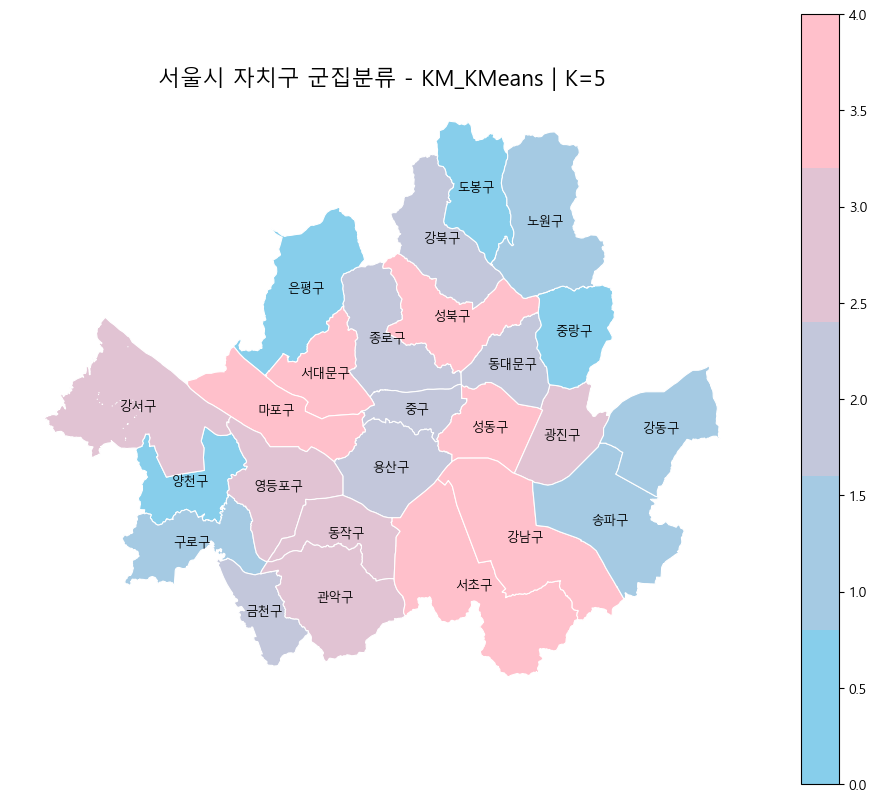

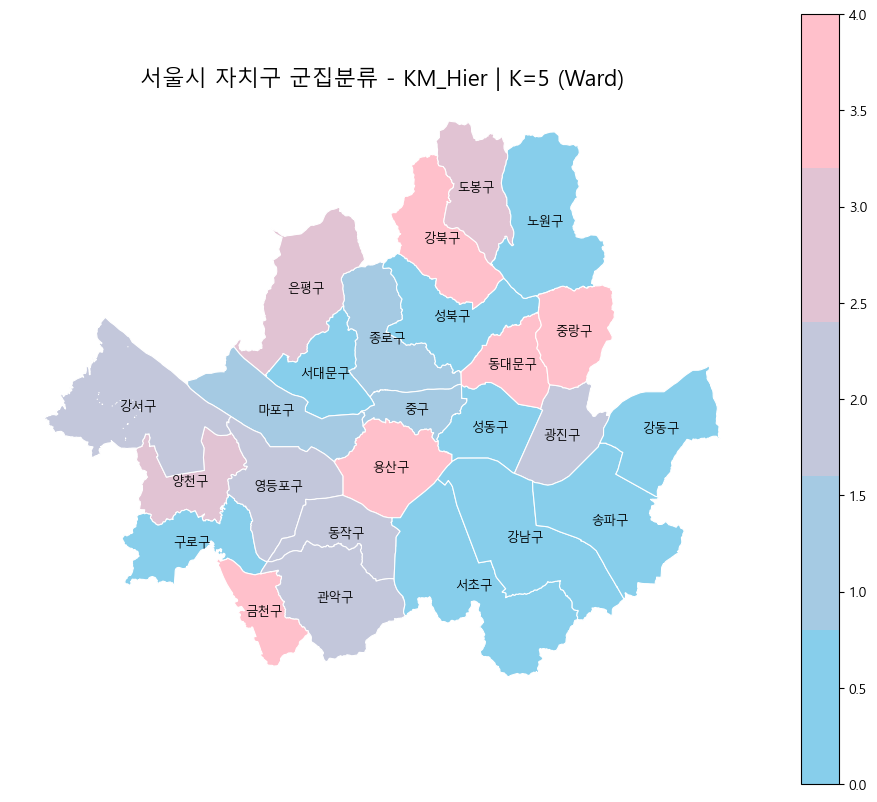

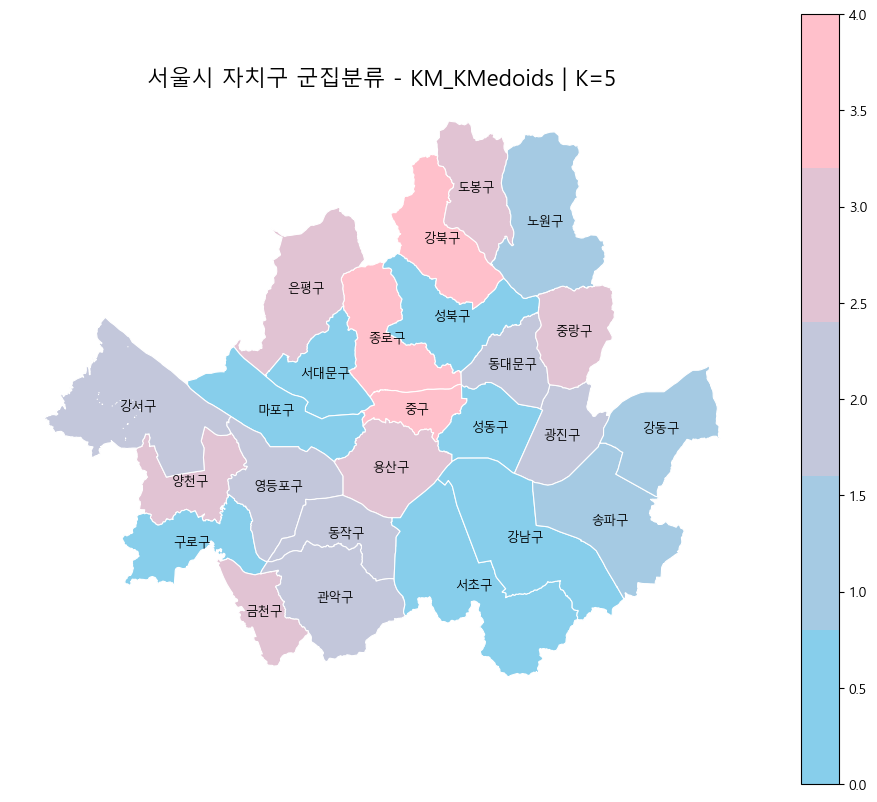

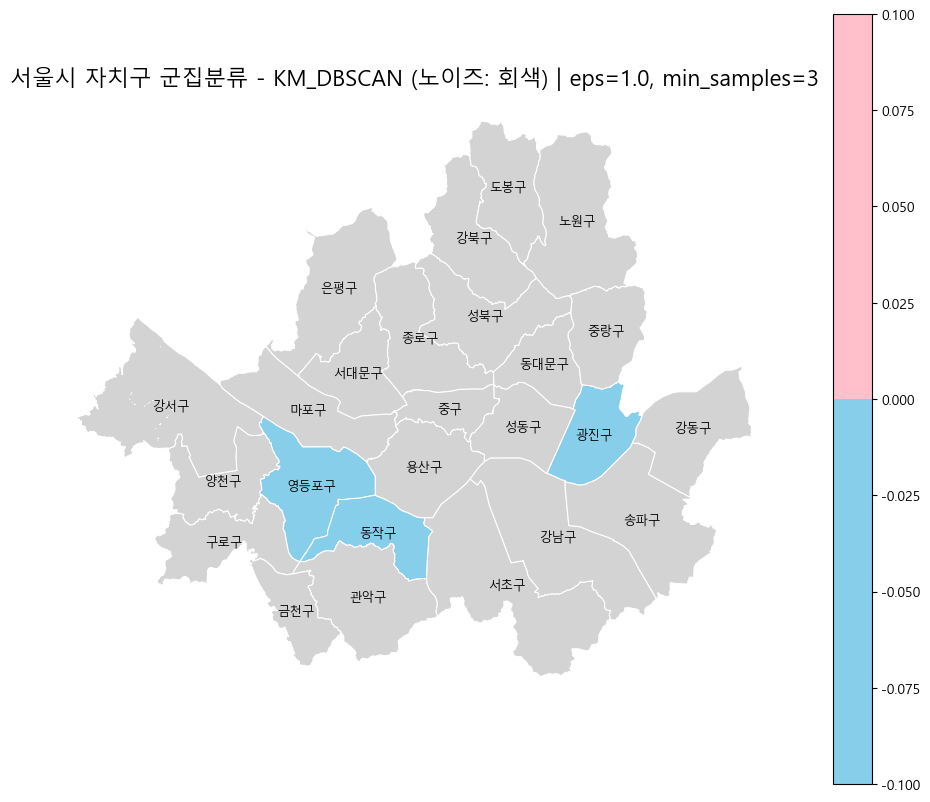

In [16]:
# 전체 시각화

plot_clusters(merged_gdf, 'KM_KMeans',   title_note=f"K={K_FIXED}")
plot_clusters(merged_gdf, 'KM_Hier',     title_note=f"K={K_FIXED} (Ward)")
plot_clusters(merged_gdf, 'KM_KMedoids', title_note=f"K={K_FIXED}")
plot_clusters(merged_gdf, 'KM_DBSCAN',   title_note="eps=1.0, min_samples=3")

In [17]:
# ------------------------------
# 6) 군집별 특성 요약 + 구 리스트
# ------------------------------
def print_cluster_summary(gdf, label_col, vars_):
    print(f"\n=== {label_col} 군집별 특성 요약 ===")
    df = gdf[gdf[label_col] != -1] if (gdf[label_col] == -1).any() else gdf
    summary = df.groupby(label_col)[vars_].mean().round(6)
    counts  = gdf[label_col].value_counts().sort_index()
    summary['count'] = counts
    print(summary)

    print("\n[군집별 자치구]")
    groups = gdf.groupby(label_col)['SIG_KOR_NM'].apply(list)
    for cid, lst in groups.items():
        print(f"Cluster {cid}: {', '.join(lst)}")

for col in ['KM_KMeans', 'KM_Hier', 'KM_KMedoids', 'KM_DBSCAN']:
    print_cluster_summary(merged_gdf, col, cluster_vars)


=== KM_KMeans 군집별 특성 요약 ===
             1인가구 비율  중증정신질환자 비율  복지 인프라 밀도  고독사 위험지수  count
KM_KMeans                                                   
0          34.270959    0.001367   0.000397  0.083066      4
1          34.115201    0.001019   0.000150  0.069630      4
2          45.258843    0.001777   0.000238  0.115523      6
3          46.848656    0.000928   0.000141  0.056535      5
4          38.096841    0.001550   0.000241  0.040451      6

[군집별 자치구]
Cluster 0: 중랑구, 도봉구, 은평구, 양천구
Cluster 1: 노원구, 구로구, 송파구, 강동구
Cluster 2: 종로구, 중구, 용산구, 동대문구, 강북구, 금천구
Cluster 3: 광진구, 강서구, 영등포구, 동작구, 관악구
Cluster 4: 성동구, 성북구, 서대문구, 마포구, 서초구, 강남구

=== KM_Hier 군집별 특성 요약 ===
           1인가구 비율  중증정신질환자 비율  복지 인프라 밀도  고독사 위험지수  count
KM_Hier                                                   
0        35.709583    0.001260   0.000206  0.053368      9
1        46.041423    0.002265   0.000233  0.086091      3
2        46.848656    0.000928   0.000141  0.056535      5
3        32.396165    0.001323   0

- 메인 결과 : KMeans(K=5) → “실루엣 기법 최적 K=5, 가장 직관적인 군집 분리”

- 비교 결과 : Hierarchical(K=5), K-Medoids(K=5) → “다른 알고리즘에서도 유사한 패턴 확인”

- 참고 지표 : DBSCAN → “밀도 기반으로는 뚜렷한 군집이 나오지 않음”

🔴 Cluster A – 고위험군

- 특징 : 1인가구 비율이 높고, 고독사 위험지수도 가장 높은 그룹

- 해당 구 : 중구, 종로구, 용산구, 강북구, 금천구 등 (지도에서 중심부+외곽 일부로 묶임)

---

🟣 Cluster B – 중상위 위험군

- 특징 : 1인가구 비율은 높으나 복지 인프라가 부족

- 해당 구 : 성북구, 중랑구, 은평구 등

---

🔵 Cluster C – 중위험군

- 특징 : 위험지수는 중간 수준, 일부 구에서 1인가구 비율은 높지만 복지 인프라는 조금 있음

- 해당 구 : 강동구, 송파구, 양천구 등

---

🟡 Cluster D – 중저위험군

- 특징 : 위험지수가 낮음, 복지 인프라도 비교적 갖춰짐

- 해당 구 : 강남구, 서초구, 관악구 등

---

🟢 Cluster E – 저위험군

- 특징 : 1인가구 비율 낮고 복지 인프라 밀도가 높은 편

- 해당 구 : 강서구, 구로구, 영등포구 등

[Cluster 0] (중위험군 / 위험지수 0.0831)
→ 성동구, 중랑구, 도봉구, 은평구, 서대문구, 양천구, 서초구, 강남구

[Cluster 1] (저위험군 / 위험지수 0.0602)
→ 광진구, 성북구, 노원구, 강서구, 구로구, 영등포구, 동작구, 관악구, 송파구, 강동구

[Cluster 2] (고위험군 / 위험지수 0.1049)
→ 종로구, 중구, 용산구, 동대문구, 강북구, 마포구, 금천구

[Cluster 3, 4]
평균값 기준으로 보면 **저위험군 (0.0565 / 0.0405)**에 해당